# Continuity
### In this notebook, we document the experiments on the reconstruction error for a fixed and known noise model on three different image resolutions. 

### We first import the packages and the data we need. For more information on the pre-saved operators and coefficients, please refer to the README.

In [1]:
## necessary to compute reconstructions
# packages
import numpy as np
from skimage.transform import resize

# custom classes and functions
from ops import reco_op, svd_op
from filters import filter
## necessary to load pre-saved operators
import pickle

## necessary for image loading and visualization
import matplotlib.pyplot as plt

In [2]:
# specify custom data location
data_folder = "spectralData"

# load pre-saved radon operators
with open(data_folder + "/radon_32.obj", "rb") as f:
    r32 = pickle.load(f)
with open(data_folder + "/radon_64.obj", "rb") as f:
    r64 = pickle.load(f)
with open(data_folder + "/radon_128.obj", "rb") as f:
    r128 = pickle.load(f)

resolutions = [32, 64, 128]    
    
r_res = {32: r32, 64: r64, 128: r128}

# load pre-saved data coefficients for the above operators and a subset of 2400 test instances of the LoDoPaB CT Dataset.
Pi_res = {res: np.loadtxt(data_folder + "/pi"+str(res)+".txt") for res in resolutions}

# load example image and resize it to different resolutions
ex_img = plt.imread(data_folder + "/test_img.png")[..., 0]

img_res = {res: resize(ex_img, (res,res)) for res in resolutions}

# compute and store the corresponding sinograms
sino_res = {res: r_res[res](img_res[res]) for res in resolutions} 

### 🔎 Let's have a look at the images and corresponding sinograms we are trying to reconstruct

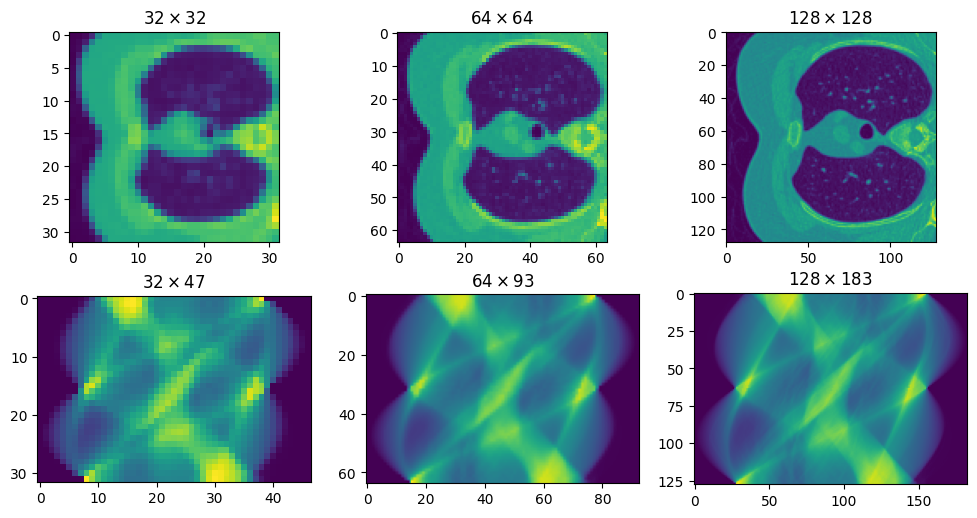

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for i,res in enumerate(resolutions):
    axs[0,i].imshow(img_res[res])
    axs[1,i].imshow(sino_res[res])

## titles
axs[0, 0].set_title(r"$32 \times 32$")
axs[1, 0].set_title(r"$32 \times 47$")
axs[0, 1].set_title(r"$64 \times 64$")
axs[1, 1].set_title(r"$64 \times 93$")
axs[0, 2].set_title(r"$128 \times 128$")
axs[1, 2].set_title(r"$128 \times 183$")
plt.show()

### In this example, we add specific noise of norm $\|\epsilon\| = 0.001$  to the sinograms.
#### More precisely, we only add noise into the direction of the 'last' eigenvector: The one that corresponds to the smallest singular value.

In [4]:
# compute worst-case noise
delta = 0.001
noisy_res = {res: sino_res[res] + delta*res*r_res[res].V[:,-1].reshape((res,-1)) for res in resolutions}

### 🔎 This amount of noise is (almost) imperceptible:

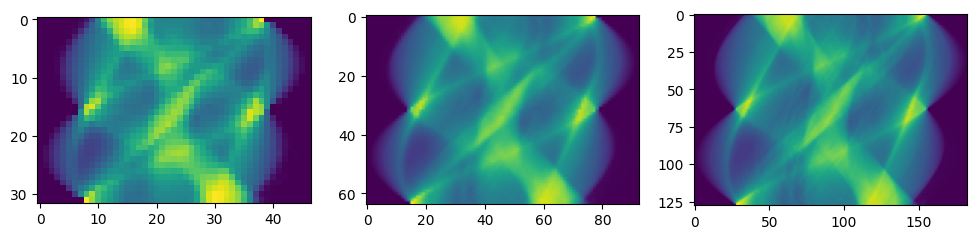

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

for i in range(len(resolutions)):
    axs[i].imshow(noisy_res[resolutions[i]])
plt.show()

### Let's compute the reconstruction errors obtained for the noisy data with all methods and all three resolutions: 
#### ⏳ Depending on your machine, this might take a while.

In [6]:
# store all results for visualization in this dict:
errors = {"nofilter": [], "mse": [], "post": [], "adv": []}


# iterate over methods
for method in errors.keys():

    # iterate over the resolutions
    for res in resolutions:
        # load example data
        img = img_res[res]
        sino = sino_res[res]

        # load operator
        r = r_res[res]

        # load data coefficients and compute filter coefficients
        Pi = Pi_res[res]
        # this filter corresponds to a filter trained on white noise (the most stable option)
        g = filter(Pi, delta**2, r.sigma, method=method)

        # build reconstruction operator (this might take a while due to a matrix-matrix multiplication)
        rec_op = reco_op(r.U, r.V, g, res)        
        
        # compute reconstruction and the corresponding L^2-error
        sino_noisy = noisy_res[res]
        reco = rec_op.reconstruct(sino_noisy)
        err= np.linalg.norm(reco - img)/res

        # store and print result
        errors[method].append(err)
        print("Error for method '" + str(method) + "' and resolution " + str(res) + ": " + str(err))

Error for method 'nofilter' and resolution 32: 1.1998529434204102
Error for method 'nofilter' and resolution 64: 2.593967914581299
Error for method 'nofilter' and resolution 128: 6.29456090927124
Error for method 'mse' and resolution 32: 0.01369621646373959
Error for method 'mse' and resolution 64: 0.0136493378855934
Error for method 'mse' and resolution 128: 0.015190141808089166
Error for method 'post' and resolution 32: 1.1976478201256373
Error for method 'post' and resolution 64: 2.5908168445884088
Error for method 'post' and resolution 128: 6.2846554162926855
Error for method 'adv' and resolution 32: 0.023820491418844982
Error for method 'adv' and resolution 64: 0.025902501431333845
Error for method 'adv' and resolution 128: 0.03207753260372441


### 🔎 Visualization of the reconstruction error

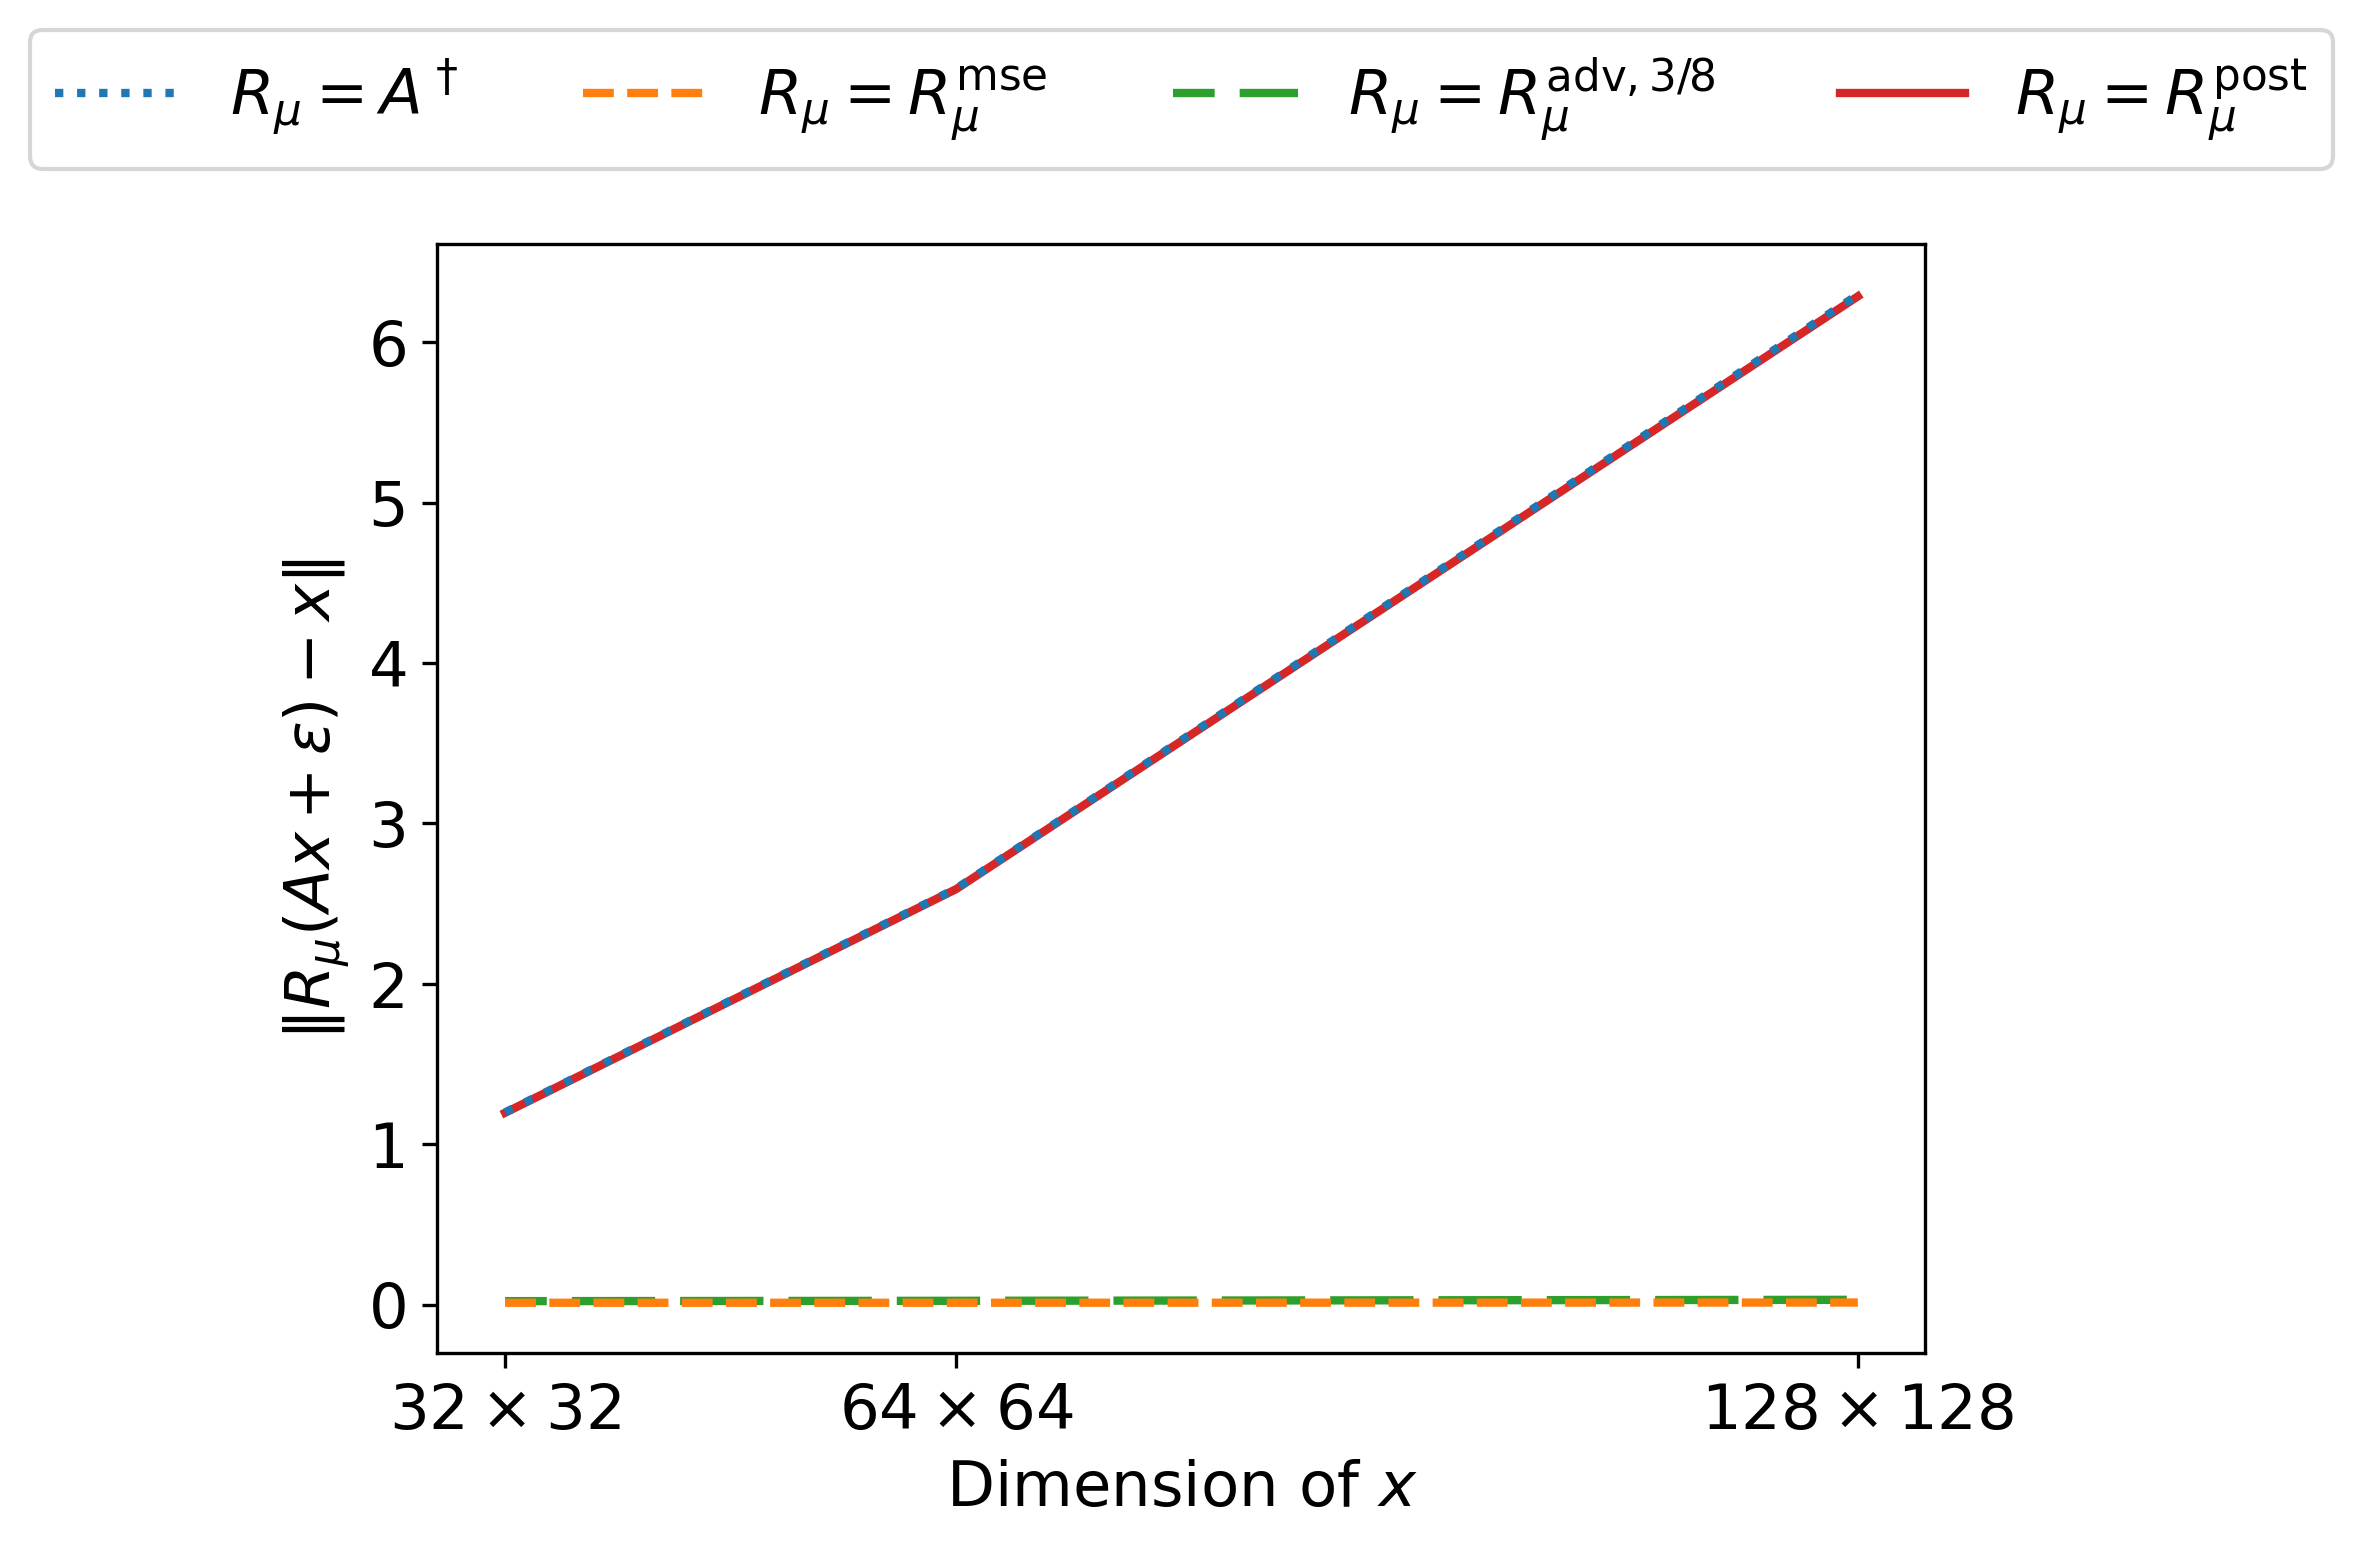

In [7]:
f = plt.figure(dpi=300)

plt.plot(resolutions, errors["adv"], ls=(5, (10, 3)), linewidth=2, label= r"$R_{\mu} =R^{\mathrm{adv},3/8}_{\mu}$",color='tab:green')
plt.plot(resolutions, errors["mse"], linewidth=2, ls="dashed", label= r"$R_{\mu} =R^{\mathrm{mse}}_{\mu}$",color='tab:orange')
plt.plot(resolutions, errors["post"], ls="solid", linewidth=2, label= r"$R_{\mu} =R^{\mathrm{post}}_{\mu}$",color='tab:red')
plt.plot(resolutions, errors["nofilter"], ls="dotted", linewidth=2, label= r"$R_{\mu} = A^\dagger$",color='tab:blue')

plt.ylabel(r"$\| R_{\mu} (Ax+\epsilon) - x \|$", fontsize=15,)
plt.xlabel("Dimension of $x$", fontsize=15)
plt.xticks(ticks=resolutions, labels=[r"$32\times 32$", r"$64\times 64$", r"$128\times 128$"], fontsize=15,)
plt.yticks(fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,1,0,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=15, bbox_to_anchor=(0.5, 1.04), loc="lower center", ncol=4);